## Objective : Lung cancer detection based on CT scan images
Lung cancer is a major cause of cancer-related deaths worldwide, and CT scan images are commonly used for detecting individuals with a high risk of lung cancer. 
The objective of this project is to develop an AI model that can accurately detect whether lesions in the lungs are cancerous or not, using a dataset of 888 high-resolution lung CT scans provided by the National Cancer Institute. The model will specifically detect pulmonary nodules, which are abnormal growths or masses of tissue in the lungs that may or may not be cancerous. 
This will help reduce the false positive rate of current detection technology, provide earlier access to life-saving interventions for patients, and give radiologists more time to spend with their patients.

## Dataset : LUNA16
The LUNA16 dataset contains 888 CT scans, which were gathered from LIDC-IDRI. There are totally 1,186 annotations of nodules that were marked by more than one radiologists. Nodules annotated by at least 3 radiologists are regarded as true nodules, whose annotations of diameters and positions are the average of annotation in LIDC-IDRI. T

# Data preprocessing
Before training the model, we will remove unwanted parts of chest CT Scans wich the dataset of luna16 contains, also we will normalize all of the 3d images to have same "spacing" between voxels.


* **what is slice thickness?** 

In CT scan images, slice thickness (or spacing) refers to the (often axial) resolution of the scan. Slice Increment refers to the movement of the CT scanner for scanning the next slice (varying from 1 mm to 4 mm).


* **What are axial, sagittal, coronal?**

These are image reconstruction planes.

![axial, sagittal, coronal](https://www.ipfradiologyrounds.com/_images/reconstruction-planes.png)


# Import Library

In [2]:
import pandas as pd
import numpy as np
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

# from PIL import Image
from glob import glob
import SimpleITK as sitk
from matplotlib import pyplot as plt
import scipy.misc

# Load dataset



In [3]:
DATASET_PATH = "original_dataset"
CLASS_TO_LABEL = {0 : "negatives", 1 : "positives"}
OUTPUT_PATH = "preprocessed_dataset"

annotations = pd.read_csv(os.path.join(DATASET_PATH ,'annotations.csv')) #nodule annotations by radiologist
candidates = pd.read_csv(os.path.join(DATASET_PATH ,'candidates_V2.csv')) #candidate nodules. see https://luna16.grand-challenge.org/Data/ for detail

In [4]:
file_list=glob(os.path.join(DATASET_PATH, 'subset*', "*.mhd"))
print(f"found {len(file_list)} CT images")

found 888 CT images


To load LUNA16 dataset (.mhd files) we will use the SimpleITK package

In [5]:
def load_itk(filename):
    # Reads the image using SimpleITK
    itkimage = sitk.ReadImage(filename)

    # Convert the image to a  numpy array first and then shuffle the dimensions to get axis in the order z,y,x
    image_array = sitk.GetArrayFromImage(itkimage)

    # Read the origin of the ct_scan, will be used to convert the coordinates from world to voxel and vice versa.
    origin = np.array(list(reversed(itkimage.GetOrigin())))

    # Read the spacing along each dimension
    spacing = np.array(list(reversed(itkimage.GetSpacing())))

    return image_array, origin, spacing

Now let's take a look at voxel values to know the distribution of them.

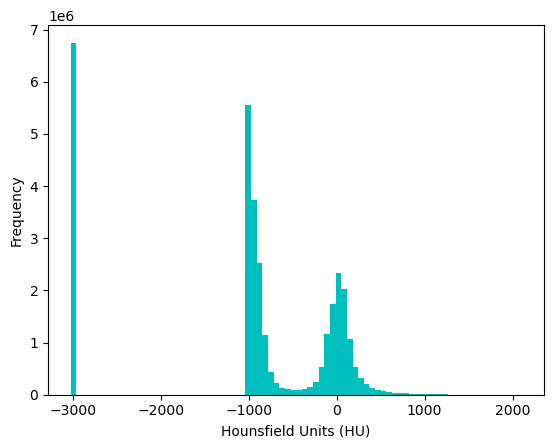

In [6]:
img, origin, spacing = load_itk(file_list[0])
plt.hist(img.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Resample images to isomorphic spacing

Since CT Scans have different spacings between voxels, which is because of that the different devices have different configurations, we will unify all of the 3d images spacings into isomorphic form of 1mm in each axis (or sagittal, coronal, and axial plane).

In [7]:
def resample(image, previous_spacing, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array(previous_spacing, dtype=np.float32)
    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

In [8]:
img2, spacing2 = resample(img, spacing)

In [9]:
print(img.shape, spacing)
print(img2.shape, spacing2)

(121, 512, 512) [2.5        0.76171899 0.76171899]
(302, 390, 390) [1.00165563 1.00000031 1.00000031]


# Normalization and zero centering
CT scans are represented as Hounsfield unit.
The Hounsfield scale of tissue density is based on two values: air as -1000HU (minimum HU value) and water as 0HU. Density of other tissues is related to this range, usually from -1000 to +1000HU (Lung parenchyma ranges from -850HU to -910HU, while bones are ranging from 700HU to 3000HU)

Therefore, we will truncate voxel values outside [-1000.0, 600.0] and scale the values to be inside [0.0, 1.0].

Afterwards, we will zero center images. But it is not per image, it is based on the mean of the whole dataset.
Mean value of LUNA16 is about 0.25.

**Note: Do not zero center with the mean per image. The CT scanners are calibrated to return accurate HU measurements. There is no such thing as an image with lower contrast or brightness as in normal pictures.**


In [10]:
def normalize(image):
    MIN_BOUND = -1000
    MAX_BOUND = 600.
    PIXEL_MEAN = 0.25
    
    image2 = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image2[image2 > 1] = 1.
    image2[image2 < 0] = 0.
    
    image2 = image2 - PIXEL_MEAN
    return image2


In [11]:
img3 = normalize(img2)

Before normalization :


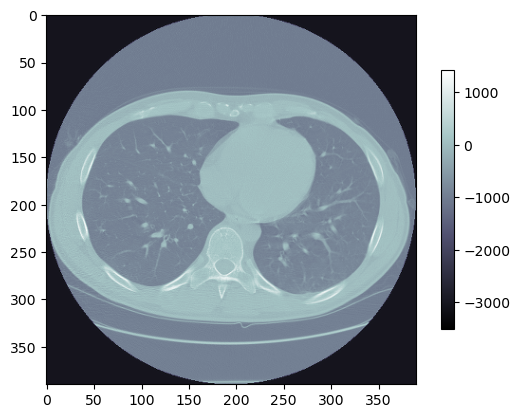

After normalization :


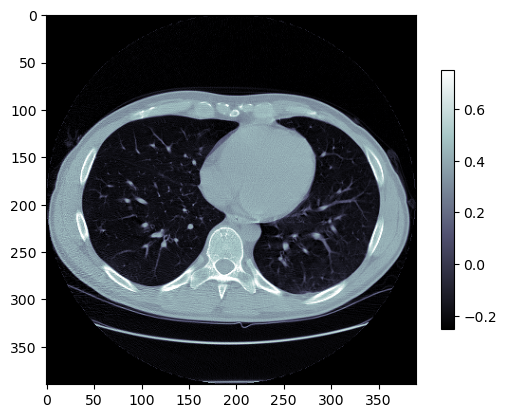

In [12]:
plt.imshow(img2[100,:,:], cmap=plt.cm.bone)
print("Before normalization :")
plt.colorbar(shrink=0.7)
plt.show()
print("After normalization :")
plt.imshow(img3[100,:,:], cmap=plt.cm.bone)
plt.colorbar(shrink=0.7)
plt.show()

We are going to preprocess all the CT scan images and save it as .npy file

Annotations will be saved as preprocessed_meta.csv file

In [19]:
def world_to_voxel_coordinate(center_world_coord, origin, spacing):
    # convert world-coordinate into voxel-coordicate
    stretchedVoxelCoord = np.absolute(np.array(center_world_coord) - np.array(origin))
    voxelCoord = stretchedVoxelCoord / np.array(spacing)
    return voxelCoord.astype(int)

def save_preprocessed_data(file_list, annotations, candidates):
    [os.makedirs(d, exist_ok=True) for d in
     [f'{OUTPUT_PATH}/positives', f'{OUTPUT_PATH}/negatives']]

    file_uids = [os.path.split(f)[-1][:-4] for f in file_list] #UIDs of CT scan images
    annotated_uids = annotations['seriesuid'].tolist() # annotated UIDs
    cancerous_uids = [f for f in file_uids if f in annotated_uids] #CT scan images with annotations are cancerous
    clean_uids =  [f for f in file_uids if f not in annotated_uids]

    print(f"found {len(cancerous_uids)} cancerous UIDs and {len(clean_uids)} negative UIDs")


    annot_list = []
    for i, series_id in enumerate(file_uids):
        cls = 1 if series_id in cancerous_uids else 0

        if cls == 1:
            nodule_coords_annot = annotations[annotations['seriesuid'] == series_id]
            nodule_centers = [(a['coordZ'], a['coordY'], a['coordX']) for a in nodule_coords_annot.iloc] #nodule centers in world coordinates
            nodule_radius = [(a['diameter_mm'] / 2) for a in nodule_coords_annot.iloc]
        else:
            nodule_coords_candid  = candidates[candidates['seriesuid'] == series_id]
            nodule_centers = [(a['coordZ'], a['coordY'], a['coordX']) for a in nodule_coords_candid.iloc]
            nodule_radius = list(np.random.randint(40, size=len(nodule_centers)))
            max_numbers_to_use = min(len(nodule_centers), 3)
            nodule_centers = nodule_centers[:max_numbers_to_use]
            nodule_radius = nodule_radius[:max_numbers_to_use]
        
        print(f"preprocessing {i+1}-th file (out of {len(file_uids)}) with class {cls} and {len(nodule_centers)} annotations")
        img, origin, spacing = load_itk(file_list[i])
        img, spacing = resample(img, spacing)
        img = normalize(img)

        nodule_centers_voxel = [tuple(world_to_voxel_coordinate(nc, origin, spacing)) for nc in nodule_centers]

        np.save(os.path.join(OUTPUT_PATH, CLASS_TO_LABEL[cls], f'{series_id}.npy'), img)

        annot = {'seriesuid': series_id, 'radii': nodule_radius, 'centers': nodule_centers_voxel,
                'spacing': list(spacing), 'class': cls}
        annot_list.append(annot)
    meta_data = pd.DataFrame.from_records(annot_list,columns=['seriesuid', 'centers', 'radii','spacing', 'class'])
    meta_data.to_csv(f'{OUTPUT_PATH}/preprocessed_meta.csv', index = False)

save_preprocessed_data(file_list, annotations, candidates)

found 601 cancerous UIDs and 287 negative UIDs
preprocessing 1-th file (out of 888) with class 0 and 3 annotations
preprocessing 2-th file (out of 888) with class 1 and 1 annotations
preprocessing 3-th file (out of 888) with class 1 and 2 annotations
preprocessing 4-th file (out of 888) with class 1 and 1 annotations
preprocessing 5-th file (out of 888) with class 0 and 3 annotations
preprocessing 6-th file (out of 888) with class 1 and 1 annotations
preprocessing 7-th file (out of 888) with class 0 and 3 annotations
preprocessing 8-th file (out of 888) with class 1 and 1 annotations
preprocessing 9-th file (out of 888) with class 1 and 1 annotations
preprocessing 10-th file (out of 888) with class 1 and 1 annotations
preprocessing 11-th file (out of 888) with class 1 and 1 annotations
preprocessing 12-th file (out of 888) with class 1 and 4 annotations
preprocessing 13-th file (out of 888) with class 1 and 2 annotations
preprocessing 14-th file (out of 888) with class 1 and 1 annotati

In [20]:
from ast import literal_eval

class LunaDataSet(Dataset):
    def __init__(self, indices: list, meta_dataframe: pd.DataFrame):
        self.indices = indices
        self.meta_dataframe = meta_dataframe

    def __getitem__(self, idx):
        meta = self.meta_dataframe.iloc[self.indices[idx]]
        centers = literal_eval(meta['centers'])
        radii = literal_eval(meta['radii'])
        cls = int(meta['class'])
        file_path = os.path.join(OUTPUT_PATH, CLASS_TO_LABEL[cls], meta['seriesuid'] + '.npy')
        img = np.load(file_path)

        return img, cls, centers, radii
        
    def __len__(self):
        return len(self.indices)

    

In [3]:
meta_df = pd.read_csv(f'{OUTPUT_PATH}/preprocessed_meta.csv') #load meta data

Display images and annotations

fisrt 3 images are positive images with cancerous nodules and next 3 images are negative images with candidate nodule annotations
image shape :  (321, 295, 295)
image shape :  (272, 340, 340)
image shape :  (316, 370, 370)
image shape :  (367, 330, 330)
image shape :  (288, 300, 300)
image shape :  (320, 317, 317)


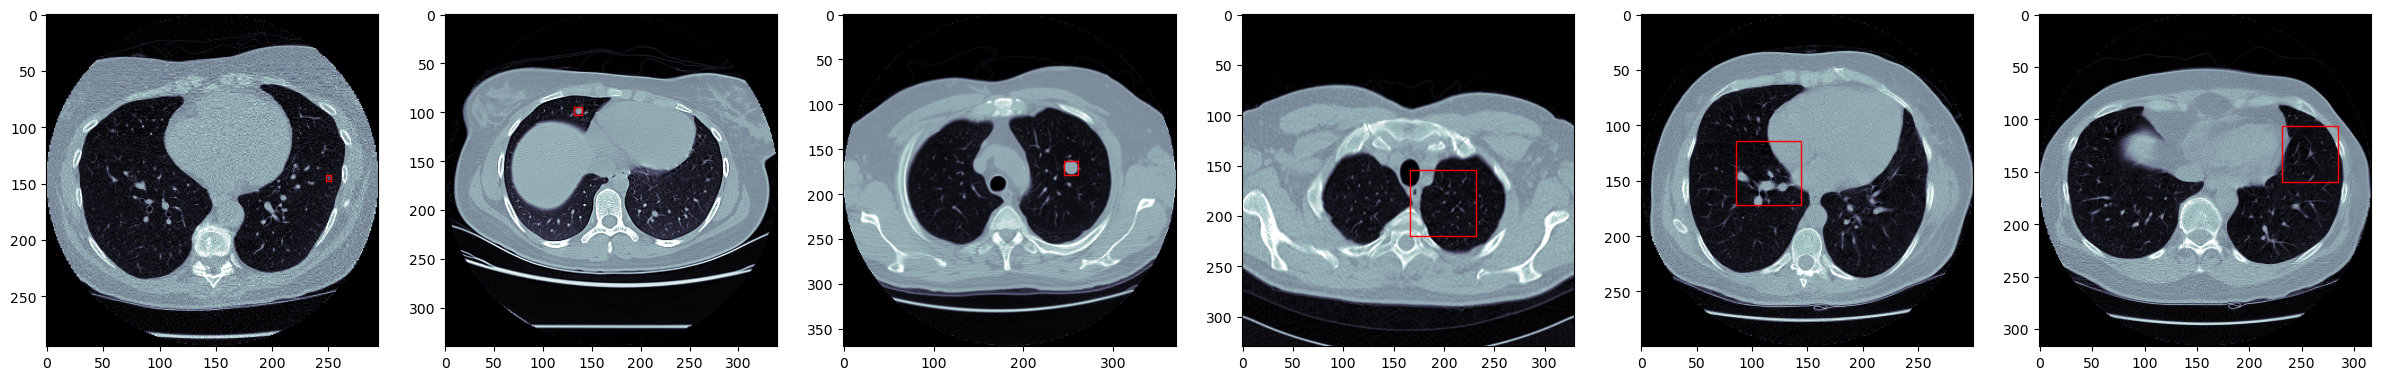

In [78]:
import matplotlib.patches as patches

example_index = meta_df.sample(frac=1).groupby("class").head(3).sort_values(by = "class", ascending=False).index.tolist()
# randomly select 3 examples from each class
example_ds = LunaDataSet(example_index, meta_df)

print("fisrt 3 images are positive images with cancerous nodules and next 3 images are negative images with candidate nodule annotations")

fig, axs = plt.subplots(1,len(example_ds), figsize=(30, 15))

for i,  x in enumerate(example_ds):
    img, cls, centers, radii = x
    center, radius = centers[0], radii[0]
    print(f"image shape : ", img.shape)

    
    # img, center : axis in the order z,y,x
    axs[i].imshow(img[int(center[0]),:,:], cmap=plt.cm.bone) # row : y, col : x     
    rect = patches.Rectangle((center[2] - radius, center[1] - radius), radius*2, radius*2, linewidth=1, edgecolor='r', facecolor='none')
    axs[i].add_patch(rect)
    # plt.colorbar(shrink=0.7)
plt.show()

### Objective:
Develop a deep learning model for classifying CT scans as containing a cancerous nodule or not, using the Vision Transformer (ViT) architecture.

### Tasks:

1. Implement a ViT-based classification model without using pre-implemented transformer or self-attention modules like torch.nn.Transformer or torch.nn.MultiheadAttention.
2. Please be aware that this problem may be highly complex and challenging, which could potentially result in poor model performance. Therefore, if the performance of your model is not satisfactory, discuss about the reasons and suggest your improvement plans.
3. Prepare a 10 to 20 minute PowerPoint presentation to explain the objective, method, and result of your AI model. Please include code when explaining the ViT model implementation. The audience should be assumed to have expertise in the field of AI, but no prior knowledge of this particular project.
4. If you have question or problem, please contact jinhyun@quantamatrix.com